In [1]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
model =init_chat_model("groq:qwen/qwen3-32b")

In [2]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages = [AIMessage(content=f"Please tell me how can i help",name="LLModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="siddu"))
messages.append(AIMessage(content=f"Please tell me which programming language you want to learn",name="LLModel"))

for msg in messages:
    msg.pretty_print()

================================== Ai Message ==================================
Name: LLModel

Please tell me how can i help
================================ Human Message =================================
Name: siddu

I want to learn coding
================================== Ai Message ==================================
Name: LLModel

Please tell me which programming language you want to learn


### Tools

In [3]:
def add(a:int,b:int)->int:
    """
    Args:
        a (int):first int
        b (int): second int

    Returns:
        int
    """

    return a+b

In [4]:
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001B3CE003610>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B3CE0E4450>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
### binding tool with llm

llm_with_tool = model.bind_tools([add])
tool_call = llm_with_tool.invoke([HumanMessage(content="what is 2 plus 2")])

In [7]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'q9a3c3dd1',
  'type': 'tool_call'}]

In [8]:
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "what is 2 plus 2". Let me see. I need to figure out if I should use the add function provided. The function takes two integers, a and b. The user\'s question is straightforward addition. So, 2 plus 2 would be the same as adding a=2 and b=2. I should call the add function with those parameters. There\'s no ambiguity here. The answer should be 4. Let me make sure the parameters are correct. Yep, both are integers. Alright, time to generate the tool call.\n', 'tool_calls': [{'id': 'q9a3c3dd1', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 171, 'total_tokens': 319, 'completion_time': 0.246111033, 'completion_tokens_details': {'reasoning_tokens': 119}, 'prompt_time': 0.006675383, 'prompt_tokens_details': None, 'queue_time': 0.051338717, 'total_time': 0.252786416}, 'model_name': 'qwen/qwen3-3

### Using Messages as state

In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [11]:
initial_messages=  [AIMessage(content="please tell me how can i help")]
initial_messages.append(HumanMessage(content="I want to learn coding"))
initial_messages

[AIMessage(content='please tell me how can i help', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={})]

In [12]:
ai_message = AIMessage(content="Which programming language you want to learn")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={})

In [13]:
add_messages(initial_messages,ai_message)

[AIMessage(content='please tell me how can i help', additional_kwargs={}, response_metadata={}, id='ffce69a1-bef3-4fb9-8b02-2afdc85d48b3'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, id='aab0f5a3-8860-4237-9791-de744aeb0071'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, id='e83dbe33-a1bf-4e33-8b2b-af2489baee2e')]

In [17]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

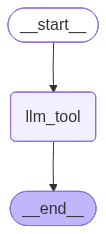

In [18]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

builder = StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)


graph_builder = builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [21]:
messages = graph_builder.invoke({"messages":"what is 2+2"})

for message in messages["messages"]:
    print(message)

content='what is 2+2' additional_kwargs={} response_metadata={} id='245f98d0-618b-4a98-a42e-88c4f73a9920'
content='' additional_kwargs={'reasoning_content': 'Okay, the user is asking "what is 2+2". I need to figure out how to respond. Let me check the tools provided. There\'s a function called add that takes two integers, a and b. The user\'s question is a simple addition problem, so I should use the add function here. The parameters are a=2 and b=2. I\'ll call the function with these values. Once I get the result, I can present the answer to the user. Let me make sure the function is correctly structured. Yep, the required parameters are there. So the tool call should be {"name": "add", "arguments": {"a": 2, "b": 2}}. Then, the result from the function will be 4, which I can then state as the answer.\n', 'tool_calls': [{'id': 'gtjyfjf6h', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 195, 'promp

In [22]:
tools = [add]

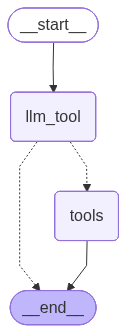

In [25]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",tools_condition)
builder.add_edge("tools",END)


graph_builder = builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [27]:
messages = graph_builder.invoke({"messages":"what is 2+2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2+2
================================== Ai Message ==================================
Tool Calls:
  add (7q3ndpfww)
 Call ID: 7q3ndpfww
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [29]:
messages = graph_builder.invoke({"messages":"what is Machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is Machine learning
================================== Ai Message ==================================

I don't have access to external tools to provide a definition, but I can explain that **machine learning** is a subset of artificial intelligence (AI) where systems learn patterns from data, identify relationships, and make predictions or decisions without being explicitly programmed for specific tasks. It involves training algorithms on datasets to improve performance over time. Common applications include image recognition, recommendation systems, and natural language processing.


### Chatbot with multiple tools

In [30]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [31]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv  = ArxivQueryRun(
    api_wrapper=api_wrapper_arxiv
)

print(arxiv.name)

arxiv


In [34]:
arxiv.invoke("Attention is all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [37]:
arxiv.invoke("What is Machine Learning")

'Published: 2023-06-07\nTitle: Changing Data Sources in the Age of Machine Learning for Official Statistics\nAuthors: Cedric De Boom, Michael Reusens\nSummary: Data science has become increasingly essential for the production of official statistics, as it enables the automated collection, processing, and analysis of large amounts of data. With such data science practices in place, it enables more timely, more insightful and more flexible reporting. However, the quality and integrity of data-science-'

In [39]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [41]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [43]:
tavily.invoke("provide me recent AI news for december 12th 2025")

[{'title': "Three Biggest AI Stories in Dec. 2025: 'AI Litigation Task Force'",
  'url': 'https://etcjournal.com/2025/12/12/three-biggest-ai-stories-in-dec-2025-ai-litigation-task-force/',
  'content': "“AI News & Trends December 2025: Complete Monthly Digest,” by HumAI Editorial Team, HumAI blog, Dec 4, 2025: “Anthropic has released a new model, Claude Opus 4.5, which outperformed all human job candidates in the company’s internal engineering tests, setting a new record in AI capabilities.” [...] “Trump targets state AI laws and major flooding in the Pacific Northwest: Morning Rundown,” by Christian Orozco, NBC News, Dec 12, 2025: “The order directs Attorney General Pam Bondi to create an ‘AI Litigation Task Force’… to challenge State AI laws that clash with the Trump administration’s vision for light-touch regulation.” [...] |  |  |\n --- |\n|  | Sutskever’s Radical… on Ilya Sutskever Says AI’s… |\n|  | How Writ of Mandamus… on ChatBot: More on AI-Driven Pee… |\n|  | How Writ of Mand

In [44]:
wiki_wrapper = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(
    api_wrapper=wiki_wrapper
)

wiki.name

'wikipedia'

In [ ]:
## combine all the tools in a list
tools = [arxiv,wiki,tavily]

In [47]:
llm_with_tools = model.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001B3CE003610>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B3CE0E4450>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 

In [49]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': '95k1q1jxx',
  'type': 'tool_call'}]

In [50]:
llm_with_tools.invoke([HumanMessage(content="What is the recent AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available tools.\n\nThe tools provided are arxiv, wikipedia, and tavily_search_results_json. Arxiv is for scientific papers, wikipedia for general knowledge, and tavily is for current events. Since the user is asking about recent news, which is likely to be current events, tavily_search_results_json seems appropriate. \n\nI should use tavily to search for the latest AI news. The query parameter should be "recent AI news" or something similar. Let me make sure the function call is correctly formatted. The name is tavily_search_results_json, and the arguments should have the query as "recent AI news". \n\nI need to output this in the specified XML tags with a JSON object inside. Let me double-check the syntax to avoid any errors. Yep, that looks right. Alright, time to make the tool call.\n', 'tool_calls': [{'id': 'am79v

### Create Chatbot 

In [51]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [52]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

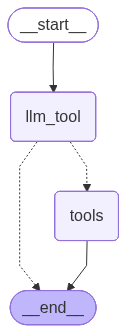

In [53]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph = builder.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [55]:
messages = graph.invoke({"messages":HumanMessage(content="what is attention is all you need")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  arxiv (qtn10b88b)
 Call ID: qtn10b88b
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2021-05-06
Title: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet
Authors: Luke Melas-Kyriazi
Summary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi


In [56]:
messages = graph.invoke({"messages":HumanMessage(content="1706.03762")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (xk1xfb9nb)
 Call ID: xk1xfb9nb
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [57]:
messages = graph.invoke({"messages":HumanMessage(content="what is machine learning")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (b5y3zhank)
 Call ID: b5y3zhank
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


In [58]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me top 10 recent AI news for December 12th 2025")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me top 10 recent AI news for December 12th 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (y2vvzt391)
 Call ID: y2vvzt391
  Args:
    query: top 10 recent AI news December 12 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Most-Read: The Stanford HAI Stories that Defined AI in 2025", "url": "https://hai.stanford.edu/news/most-read-the-stanford-hai-stories-that-defined-ai-in-2025", "content": "Stanford HAI’s 2025 AI Index revealed a technology simultaneously shrinking, cheapening, and spiraling—smaller models now match 2022's behemoths at a 142-fold parameter reduction, while costs have plummeted 280-fold in 18 months. China's models have caught up to U.S. quality (even as America still leads in quantity and investment), and businesses h

### ReAct Agents

In [60]:
def multiply(a:int,b:int)->int:
    """Multiply a and b"""
    return a*b

def divide(a:int,b:int)->float:
    """Divide a and b"""
    return a/b

In [62]:
tools = [arxiv,wiki,add,multiply,divide,tavily]

In [63]:
llm_with_tools = model.bind_tools(tools)

In [64]:
llm_with_tools.invoke("what is recent AI news")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThe tools provided include arxiv, wikipedia, add, multiply, divide, and tavily_search_results_json. The arithmetic functions don\'t seem relevant here. Arxiv is for scientific papers, and wikipedia is for general knowledge. The user is asking for recent news, which is likely about current events. The description for tavily_search_results_json mentions it\'s optimized for current events, so that\'s the right choice here. \n\nI should call tavily_search_results_json with the query "recent AI news". Let me make sure the parameters are correct. The function requires a "query" parameter, which I have. So the tool call should be properly formatted.\n', 'tool_calls': [{'id': 'ne2b1jhwg', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}

In [65]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

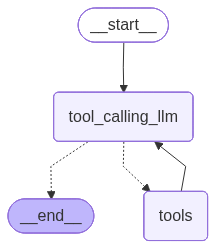

In [67]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [71]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me recent AI news for December 10th 2025, add 5 plus 5 and then multiply by 10")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me recent AI news for December 10th 2025, add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9secnh7x7)
 Call ID: 9secnh7x7
  Args:
    query: recent AI news December 10th 2025
  add (rycxm140k)
 Call ID: rycxm140k
  Args:
    a: 5
    b: 5
  multiply (v3d5fzas3)
 Call ID: v3d5fzas3
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI Insights: Key Global Developments in December 2025", "url": "https://www.riskinfo.ai/post/ai-insights-key-global-developments-in-december-2025", "content": "This month’s news spans late November through mid-December 2025, and it’s been a whirlwind. The frontier of AI continues advancing: Google launched Gemini 3 (Nov 2025), its most powerful multimodal mode